In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow import keras
from tensorflow.keras.models import Model


from tqdm import tqdm
import os
import random

# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img


In [3]:
train_dir = 'archive/Training/'
test_dir = 'archive/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)


In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [5]:
labels = os.listdir(train_dir) #add the names of the folders inside the mentioned directory to labels

train_img = [] #store images
train_img_label = [] #store corresponding label

for l in labels: #create a list of images and a list of corresponding labels.
    for img in os.listdir(train_dir+l):
        train_img.append(train_dir+l+'/'+img)
        train_img_label.append(l)
        
train_img, train_img_label = shuffle(train_img, train_img_label) #shuffle both lists in the same order to match the right label
len(train_img_label), len(train_img)


(5712, 5712)

In [6]:
#repeat steps for testing set 
test_img = []
test_img_label = []

for l in labels:
    for img in os.listdir(test_dir+l):
        test_img.append(test_dir+l+'/'+img)
        test_img_label.append(l)
        
test_img, test_img_label = shuffle(test_img, test_img_label)

len(test_img),len(test_img_label)

(1311, 1311)

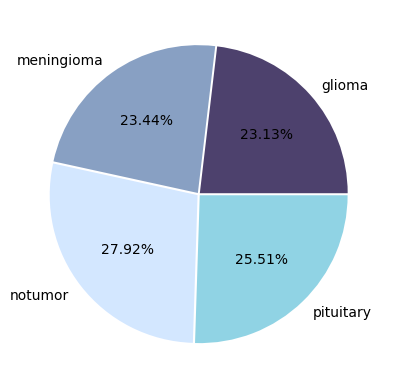

In [7]:
#Visualizing the data used for training

colors=['#4d416d','#88a0c3','#d3e7ff','#90d3e4']
plt.pie([len([l for l in train_img_label if l == labels[0]]),
         len([l for l in train_img_label if l == labels[1]]),
         len([l for l in train_img_label if l == labels[2]]),
         len([l for l in train_img_label if l == labels[3]])],
       labels=labels, autopct='%.2f%%', colors=colors, explode=(0.01,0.01,0.01,0.01))

plt.rcParams.update({'font.size':14})
plt.show()

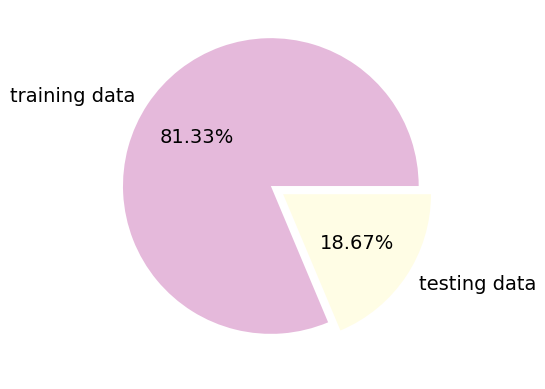

In [8]:
#visualizing training-testing ratio

plt.pie([len(train_img), len(test_img)], colors=['#e5b9db', '#fffde5'],
        labels=['training data', 'testing data'], autopct='%.2f%%', explode=(0.1,0))
plt.show()

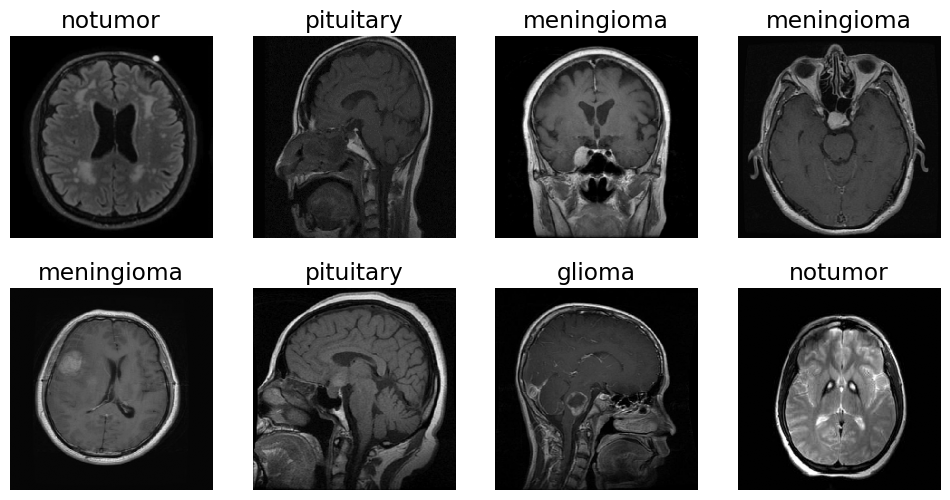

In [9]:
#Data Augmentation

from PIL import Image, ImageEnhance


IMAGE_SIZE = 224

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.array(image)
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()


In [10]:
from keras.preprocessing.image import ImageDataGenerator

# Define preprocessing parameters
batch_size = 32
target_size = (128, 128)

# Define image data generator with preprocessing options
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=30,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

# Create training data generator
train_generator = datagen.flow_from_directory(
        'archive/Training/',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

# Create validation data generator
validation_generator = datagen.flow_from_directory(
        'archive/Training/',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [11]:
# Define data generator for preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

# Load and preprocess test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [12]:
# Load the pre-trained VGG16 model and exclude the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False


In [13]:
# Add custom layers to the top of the base model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Define the transfer learning model
model_vgg = Model(inputs=base_model.input, outputs=x)


In [23]:
model_vgg.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# Display the model summary
model_vgg.summary()

TypeError: summary() got an unexpected keyword argument 'model'

In [14]:
model_vgg.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator))



Epoch 1/10
179/179 [==============================] - 866s 5s/step - loss: -2999.3669 - accuracy: 0.2344 - val_loss: -8417.1797 - val_accuracy: 0.2334
Epoch 2/10
179/179 [==============================] - 874s 5s/step - loss: -20103.2949 - accuracy: 0.2344 - val_loss: -33653.9531 - val_accuracy: 0.2334
Epoch 3/10
179/179 [==============================] - 808s 5s/step - loss: -55060.9062 - accuracy: 0.2344 - val_loss: -76444.1641 - val_accuracy: 0.2334
Epoch 4/10
179/179 [==============================] - 795s 4s/step - loss: -107448.4141 - accuracy: 0.2344 - val_loss: -135331.7344 - val_accuracy: 0.2334
Epoch 5/10
179/179 [==============================] - 789s 4s/step - loss: -176002.3438 - accuracy: 0.2344 - val_loss: -209175.0156 - val_accuracy: 0.2334
Epoch 6/10
179/179 [==============================] - 1153s 6s/step - loss: -259178.8438 - accuracy: 0.2344 - val_loss: -297643.9375 - val_accuracy: 0.2334
Epoch 7/10
179/179 [==============================] - 742s 4s/step - loss: -3

In [15]:

# Train the model and save the history object
history = model_vgg.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator))


# Extract the metrics from the history object
vgg_acc = history.history['accuracy']
vgg_val_acc = history.history['val_accuracy']
vgg_loss = history.history['loss']
vgg_val_loss = history.history['val_loss']

# Create visualizations for the metrics
sns.set(style='darkgrid')
plt.plot(vgg_acc)
plt.plot(vgg_val_acc)
plt.title('Training and Validation Accuracy for VGG-16 Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(vgg_loss)
plt.plot(vgg_val_loss)
plt.title('Training and Validation Loss for VGG-16 Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Compute the classification report for the test set
y_pred = model_vgg.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
vgg_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

# Print the classification report for the VGG-16 model
print(vgg_report)

Epoch 1/10
  4/179 [..............................] - ETA: 21:22 - loss: -27.3717 - accuracy: 0.2500

KeyboardInterrupt: 

In [16]:
# ResNet50 model
num_classes = 10
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_resnet = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model_resnet.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping


# Checkpoint to save the best model weights
checkpoint_resnet = ModelCheckpoint('resnet50_brain_tumor.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Early stopping to stop training if the validation accuracy doesn't improve
early_stop_resnet = EarlyStopping(monitor='val_accuracy',
                           patience=5,
                           mode='max',
                           verbose=1)

# Train the ResNet50 model
history_resnet = model_resnet.fit_generator(train_generator,
                                             steps_per_epoch=len(train_generator),
                                             epochs=10,
                                             callbacks=[checkpoint_resnet, early_stop_resnet],
                                             validation_data=validation_generator,
                                             validation_steps=len(validation_generator))

# Load the best weights for the ResNet50 model
model_resnet.load_weights('resnet50_brain_tumor.h5')



C:\Users\Admin\AppData\Local\Temp\ipykernel_11284\1083722063.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_resnet = model_resnet.fit_generator(train_generator,


Epoch 1/10


ValueError: in user code:

    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


In [18]:
# Evaluate the model on the test set
scores_resnet = model_resnet.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("Test loss:", scores_resnet[0])
print("Test accuracy:", scores_resnet[1])

# Get the predictions on the test set
y_pred_resnet = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_true_resnet = test_generator.classes

# Compute the confusion matrix
conf_mat_resnet = confusion_matrix(y_true_resnet, np.argmax(y_pred_resnet, axis=1))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_resnet, cmap="Blues", annot=True, fmt='g', xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print the classification report
target_names = list(train_generator.class_indices.keys())
print(classification_report(y_true_resnet, np.argmax(y_pred_resnet, axis=1), target_names=target_names))


C:\Users\Admin\AppData\Local\Temp\ipykernel_11284\2333767499.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores_resnet = model_resnet.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)


ValueError: in user code:

    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 1557, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 1546, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 1535, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 1501, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


In [22]:
# InceptionV3 model
# Define the image size
img_size = 224

# Load the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))



# Add layers to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model_inception = Model(inputs=base_model.input, outputs=predictions)

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_inception.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1_score'])
model_inception.summary()
# Define callbacks
checkpoint = ModelCheckpoint('inceptionv3_brain_tumor.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5,
                           mode='max',
                           verbose=1)

# Train the model
history_inception = model_inception.fit_generator(train_generator,
                                        steps_per_epoch=len(train_generator),
                                        epochs=10,
                                        validation_data=validation_generator,
                                        validation_steps=len(validation_generator),
                                        callbacks=[checkpoint, early_stop])



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

C:\Users\Admin\AppData\Local\Temp\ipykernel_11284\1319682932.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_inception = model_inception.fit_generator(train_generator,


Epoch 1/10


ValueError: in user code:

    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Admin\miniconda3\lib\site-packages\keras\backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


In [ ]:
# Load the best weights
model_inception.load_weights('inceptionv3_brain_tumor.h5')

# Evaluate the model on the test set
scores_inception = model_inception.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("Test loss:", scores_inception[0])
print("Test accuracy:", scores_inception[1])

# Get the predictions on the test set
y_pred_inception = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_true_inception = test_generator.classes

# Compute the confusion matrix
conf_mat_inception = confusion_matrix(y_true_inception, np.argmax(y_pred_inception, axis=1))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_inception, cmap="Blues", annot=True, fmt='g', xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
plt.title("InceptionV3 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print the classification report
target_names = list(train_generator.class_indices.keys())
print(classification_report(y_true_inception, np.argmax(y_pred_inception, axis=1), target_names=target_names))